In [3]:
import sys
sys.path.append('../')
from torchdyn.models import *
from torchdyn import *
from torchdyn.datasets import *

# Higher-Order Neural ODEs

Following [Dissecting Neural ODEs](www.aaaa.com), In this tutorial we showcase how to handle **higher-order neural ODEs** in `torchdyn`

**Data:** we use again the moons dataset (with some added noise) simply because all the models will be effective to solve the binary classification problem.



In [4]:
d = ToyDataset()
X, yn = d.generate(n_samples=128, dataset_type='moons', noise=.4)

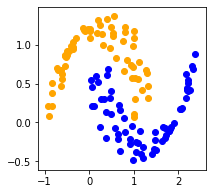

In [5]:
import matplotlib.pyplot as plt

colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], color=colors[yn[i].int()])

In [6]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=False)

**Learner**

In [9]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module): #settings:dict={}):
        super().__init__()
        #defaults.update(settings)
        #self.settings = defaults
        self.model = model
        self.c = 0
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_hat = self.model(x)  
        loss = nn.CrossEntropyLoss()(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.005)

    def train_dataloader(self):
        return trainloader

In [10]:
from torch.autograd import grad as grad

In [11]:
import pdb
class intloss(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
    def forward(self, x):
        #x.requires_grad_(True)
        loss = 1e-4*torch.abs(self.f(x)).sum(1) #grad(self.f(s, x), x, create_graph=True
        return loss

In [12]:
# vector field parametrized by a NN
f = nn.Sequential(
        nn.Linear(6, 64),
        nn.Tanh(), 
        nn.Linear(64, 2))

# neural ODE
model = NeuralDE(f, 
                 order=3,
                 solver='dopri5', 
                 sensitivity='adjoint', 
                 intloss=None).to(device)
seq = nn.Sequential(Augmenter(1, 4, order='last'), model)

In [13]:
torch.rand(10).requires_grad_(True).shape

torch.Size([10])

In [14]:
# train the neural ODE
learn = Learner(seq)
trainer = pl.Trainer(min_nb_epochs=300, max_nb_epochs=600)
trainer.fit(learn)

INFO:lightning:
  | Name               | Type       | Params
----------------------------------------------
0 | model              | Sequential | 578   
1 | model.0            | Augmenter  | 0     
2 | model.1            | NeuralDE   | 578   
3 | model.1.defunc     | DEFunc     | 578   
4 | model.1.defunc.m   | Sequential | 578   
5 | model.1.defunc.m.0 | Linear     | 448   
6 | model.1.defunc.m.1 | Tanh       | 0     
7 | model.1.defunc.m.2 | Linear     | 130   
8 | model.1.adjoint    | Adjoint    | 0     


C:\Users\stefano\Anaconda3\lib\site-packages\pytorch_lightning\utilities\warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)


tensor(2.0041, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9699, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9382, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9088, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8814, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8556, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8308, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8068, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7832, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7597, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7362, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.7124, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6882, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6636, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6386, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.6131, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.5872, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.3523, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3504, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3486, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3468, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3450, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3433, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3416, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3400, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3383, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3367, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3352, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3336, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3321, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3306, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3291, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3276, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3262, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.2275, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2270, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2266, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2261, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2257, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2253, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2248, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2244, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2240, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2236, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2231, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2227, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2223, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2219, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2215, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2211, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2207, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.1743, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1734, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1726, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1718, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1717, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1710, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1706, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1699, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1693, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1691, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1687, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1682, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1677, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1671, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1667, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1664, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1659, device='cuda:0', grad_fn=<NllLossBackward

tensor(0.0773, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0765, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0757, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0749, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0740, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0731, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0723, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0714, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0705, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0696, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0687, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0678, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0668, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0659, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0651, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0642, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0633, device='cuda:0', grad_fn=<NllLossBackward

1

**Plots**

In [34]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,100)
X_d = seq[0](X_train)
trajectory = model.trajectory(X_d, s_span).detach().cpu()

IndexError: index 0 is out of bounds for dimension 2 with size 0

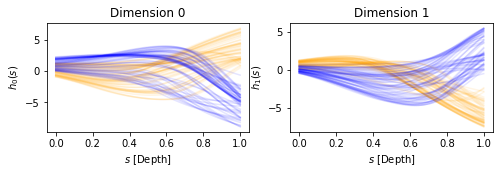

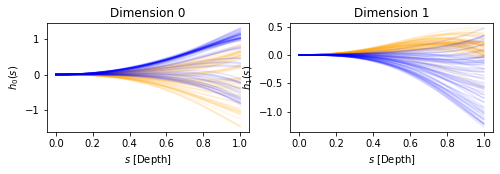

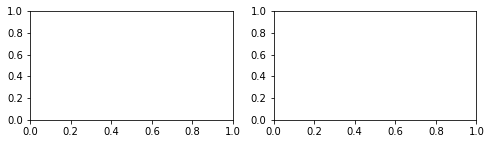

In [40]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(s_span, trajectory[:,:,-2:], yn, len(X))
plot_2D_depth_trajectory(s_span, trajectory[:,:,:2], yn, len(X))
plot_2D_depth_trajectory(s_span, trajectory[:,:,2:2], yn, len(X))

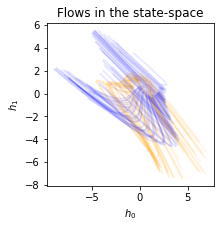

In [38]:
# Trajectories in the state-space
plot_2D_state_space(trajectory[:,:,-2:], yn, len(X),)

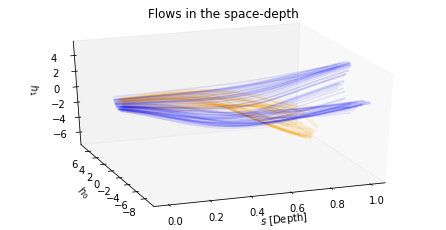

In [39]:
# Trajectories in space-depth
plot_2D_space_depth(s_span, trajectory[:,:,-2:], yn, len(X))